# Dye Plots
This notebook makes the plots of dye from the observations for Wenegrat et al. 2020

In [1]:
import h5py
import scipy.io as spio
import matplotlib.pyplot as plt
import numpy as np
from cmocean import cm as cmo
from scipy.interpolate import griddata
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch

#from matplotlib.mlab import griddata
import datetime as dt
import gsw
import scipy.interpolate as interp
from matplotlib.gridspec import GridSpec
#%%
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'


In [2]:

#%% LOAD DYE DATA
#filename = '/home/jacob/dedalus/LATMIX/LatMix_2012/inj_data_2012'
#matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
#matfile = spio.loadmat(filename,struct_as_record=True, squeeze_me=True)

filename = '/home/jacob/dedalus/LATMIX/LatMix_2012/my_triaxus_SI2'
filename = '/data/pacific/jacob/LATMIXDYE/LatMix_2012_Transfer/my_triaxus_SI2'
matfile = spio.loadmat(filename,struct_as_record=True, squeeze_me=True)


depth = matfile['DEPTH']
fluorppb = matfile['FLUORPPB']
shiplog = matfile['SHIPLOG']
rho = matfile['PDENS']
T = matfile['TEMP']
S = matfile['SALIN']
jday = matfile['JDAY']
lat = matfile['LAT']
lon = matfile['LON']
II = matfile['II'] # This indexes individual gulf stream crossings

fluorppb[np.isnan(fluorppb)] = 0
fluorppb[fluorppb<0] = 0
fluorppb[fluorppb==0] = 1e-10
nd, ns = shiplog.shape

#%% LOAD TIMESERIES DATA

jday_ts = matfile['jday_ts']
fluorppb_ts = matfile['fluorPPB_ts']
depth_ts = matfile['depth_ts']
lat_ts = matfile['lat_ts']
lon_ts = matfile['lon_ts']
rho_ts = matfile['pdens_ts']
T_ts = matfile['T_ts']
S_ts = matfile['S_ts']
    #%% LOAD FLOAT DATA
filename = '/home/jacob/dedalus/LATMIX/FloatData/Mar05_SI_2_Track.mat'
filename = '/data/pacific/jacob/LATMIXDYE/FloatData_Transfer/Mar05_SI_2_Track.mat'
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
floatstruct = matfile['F']
flat = floatstruct.lat
flon = floatstruct.lon
fyd = floatstruct.yd-1 #Craig convention

fyds = floatstruct.yds - 1
flats = floatstruct.lats
flons = floatstruct.lons

#sf = 10
#poly = np.polyfit(fyd,flat,6)
#flat_s = np.poly1d(poly)(fyd)
#
#window_size, poly_order = 51, 3
#flat_s = savgol_filter(flat, window_size, poly_order, deriv=0)
#flon_s = savgol_filter(flon, window_size, poly_order, deriv=0)
fvellat = np.gradient(flats)/np.gradient(fyds*86400)
fvellon = np.gradient(flons)/ np.gradient(fyds*86400)
fdir = np.arctan2(fvellat, fvellon)

filename = '/home/jacob/dedalus/LATMIX/FloatData/Env.mat'
filename = '/data/pacific/jacob/LATMIXDYE/FloatData_Transfer/Env.mat'

matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
fT = matfile['T']
fS = matfile['S']
fT = np.mean(fT, axis=-1)# Top and bottom sensors
fS = np.mean(fS, axis=-1)
fydr = matfile['yd'] - 1
fP = matfile['P']


In [3]:
#%% Calculated depth integrated 
# Might be easier to do from gridded data

# NB. Need to figure out how to calculate across-stream distance for each cast, otherwise
# Nb. Also need to figure out how to interpolate/plot surface density for each of these.

# 1 ) At each point, calculate distance from float
# 2 ) Using instantaneous float velocity calculate cross-stream distance

fluor_int = np.zeros((ns,))
lat_int = np.zeros((ns,))
lon_int = np.zeros((ns,))
jday_int = np.zeros((ns,))
surf_rho = np.zeros((ns,))
shiplog_int = np.zeros((ns,))
zcom_rho = np.zeros((ns,))
zcom_t = np.zeros((ns,))
zcom_s = np.zeros((ns,))
zcom_si = np.zeros((ns,))
zcom_ti = np.zeros((ns,))
zcom_rhoi = np.zeros((ns,))
for i in range(0, ns):
    mask = np.isfinite(fluorppb[:,i])
    fluor_int[i] = integrate.trapz(fluorppb[mask,i], x=depth[mask,i])
    shiplog_int[i] = np.nanmean(shiplog[mask,i])
    lat_int[i] = np.nanmean(lat[:,i])
    lon_int[i] = np.nanmean(lon[:,i])
    jday_int[i] = np.nanmean(jday[:,i])
    ind = np.where(np.isfinite(rho[:,i]))[0][0]
    zcom = integrate.trapz(fluorppb[mask,i]*depth[mask,i], x=depth[mask,i])/fluor_int[i]
    surf_rho[i] = rho[ind,i]
    ind = np.argmin(np.abs(depth[:,i] - zcom))
    zcom_rho[i] = rho[ind,i]
    zcom_t[i] = T[ind,i]
    zcom_s[i] = S[ind,i]
    mask = np.logical_and(mask, np.isfinite(T[:,i]+S[:,i]))
    zcom_ti[i] = integrate.trapz(fluorppb[mask,i]*T[mask,i], x=depth[mask,i])/fluor_int[i]
    zcom_si[i] = integrate.trapz(fluorppb[mask,i]*S[mask,i], x=depth[mask,i])/fluor_int[i]
    zcom_rhoi[i] = integrate.trapz(fluorppb[mask,i]*rho[mask,i], x=depth[mask,i])/fluor_int[i]


# calc distance relative to float
#iflat = np.interp(jday_int, fyds, flats)
#iflon = np.interp(jday_int, fyds, flons)
#distlat = (lat_int-iflat)*111e3*np.cos(lat_int)
#distlon = (lon_int-iflon)*111e3

#fdist = np.sign(lat_int-iflat)*np.sqrt(((lat_int - iflat)*111e3*np.cos(lat_int))**2 + ((lon_int - iflon)*111e3)**2)

In [6]:
# Here we identify the density, T, and S at the COM of each section
# We do this by integrating each cast of the section in depth and treating as a single horizontal point
# Next find the horizontal COM.
# Then integrate horizontally across the section and find the vertical COM.

nc = len(II)

jday_sect = np.zeros((nc,))
rho_COM_SECT = np.zeros((nc,))
t_COM_SECT = np.zeros((nc,))
s_COM_SECT = np.zeros((nc,))

#find maximum section integrated dye (an alternate approach for masking noise)
i = 4
span = range(II[i,0], II[i,1])
mask = np.isfinite(fluorppb[:,span])
dz = depth[1,0] - depth[0,0]
ftemp = np.nansum(fluorppb[:,span], axis=0)*dz
sltemp = np.nanmean(shiplog[:,span], axis=0)*1000
mask = np.isfinite(ftemp)
maxppb = integrate.trapz(ftemp[mask], x=sltemp[mask])
#maxppb = np.nansum(ftemp)

# Iterate over each crossing
for i in range(0,nc):
    span = range(II[i,0], II[i,1])
    
    nd, ls = np.array(jday[:,span]).shape
    jday_sect[i] = np.nanmean(jday[:,span]) # mean day of the section
    
    print(f'Yearday: {jday_sect[i]}')
    mask = np.isfinite(fluorppb[:,span])
    fl = fluorppb[:,span]

    
    ftemp = fl/np.nanmax(fluorppb) #Normalized concentration

    # If using the integrated concentration as cutoff:
    #ftempi = np.nansum(fluorppb[:,span], axis=0)*dz
    #sltemp = np.nanmean(shiplog[:,span], axis=0)*1000
    #mask = np.isfinite(ftempi)
    #secppb = integrate.trapz(ftempi[mask], x=sltemp[mask])
    #secppb = np.nansum(ftempi)
    #print(f'Section {i}, ppb is {secppb}')
    #if secppb < 1e-2*maxppb:
    #    ftemp = np.nan*ftemp
    #ftemp[ftemp<10**(-2)] = np.nan # We limit the calculation to those places where the concentration is >1/1000 of the maximum observed, otherwise too noisy
    
    # Else use a ppb cutoff to avoid noise
    ftemp[fl<1e-2] = 0 #Noise floor from Sundermeyer et al. 2020 JPO
    depthtemp = depth[:,span]
    
    # Here we essentially treat each column in the gridded dye as a discrete point in x:
    # Iterate over each part of the section and integrate vertically
    dyeint = np.zeros((ls,))
    for j in range(0,ls): # Integrate vertically at each step (cast) in the section)
        mask = (np.isfinite(ftemp[:,j]))&(depth[:,j]<120)
        if np.sum(mask)>4: # Avoid fringes of casts
            dyeint[j] = integrate.trapz(ftemp[mask,j], x=depthtemp[mask,j],axis=0 )    
    x = shiplog[:,span]
    xint = np.nanmean(x,axis=0) # Integrate the horizontal position at each cast
    XCOM = integrate.trapz(xint*dyeint, x=xint)/integrate.trapz(dyeint, x=xint) # Calculate the hor. COM

    print(f'X center of mass position: {XCOM}')
    
    # Now interate horizontally to find the vertical center of mass:
    dyeinth = np.zeros((nd,))
    for j in range(0, nd):
        mask = np.isfinite(ftemp[j,:])
        if np.sum(mask)>4: # avoid fringes (near top and bottom of casts) without much data
            dyeinth[j] = integrate.trapz(ftemp[j,mask], x=xint[mask], axis=-1)
    
    mask = depth[:,0]<120
    VCOM = integrate.trapz(depth[mask,0]*dyeinth[mask], x=depth[mask,0])/integrate.trapz(dyeinth[mask], x=depth[mask,0]) # restrict z coordinate
    zind = np.argmin(np.abs(depth[:,0]-VCOM))
    
    # Now we pick out the (rho, T, S) value at the horizontal and vertical center of mass
    # We interpolate in the horizontal as the X grid is much coarser than Z.
    rho_COM_SECT[i] = interp.interp1d(xint, rho[zind,span], kind='linear')(XCOM)#np.interp(XCOM, xint, rho[zind,span])
    s_COM_SECT[i] = interp.interp1d(xint, S[zind,span], kind='linear')(XCOM)#np.interp(XCOM, xint, S[zind,span])
    t_COM_SECT[i] = interp.interp1d(xint, T[zind,span], kind='linear')(XCOM)#np.interp(XCOM, xint, T[zind,span])

    # Below are some alternate approaches:
    ##############################################
    # Alternately, find the XCOM and then find the vertical COM at that point
    #xind = np.argmin(np.abs(xint - XCOM))
    #mask = (np.isfinite(ftemp[:,xind])) & (depth[:,xind]<120)
    #print(np.sum(mask))
    #VCOM = integrate.trapz(depth[mask,xind]*ftemp[mask,xind], x=depth[mask,xind])/integrate.trapz(ftemp[mask,xind], x=depth[mask, xind])
    #zind = np.argmin(np.abs(depth[:,0]-VCOM))

    #rho_COM_SECT[i] = rho[:,span][zind,xind]
    #s_COM_SECT[i] = S[:,span][zind,xind]
    #t_COM_SECT[i] = T[:,span][zind,xind]


    # Instead find horizontal COM at each depth and then average (as in variance calcs)
    # Not sure this works because what will I do then? Average the XCOM over some depth range?
    #XCOM = np.zeros((nd,))
    #for j in range(0, nd):
    #    xtemp = x[j,:]
    #    ftemp = fluorppb[j,span]
    #    mask = np.isfinite(xtemp+ftemp)
    #    if np.sum(mask)>4:
    #        XCOM[j] = integrate.trapz(xtemp[mask]*ftemp[mask], x=xtemp[mask])
    


Yearday: 64.95168536184255
X center of mass position: 1.230999660104169
Yearday: 64.98757140259336


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars


X center of mass position: nan
Yearday: 65.03440996125774
X center of mass position: 36.834344943853445
Yearday: 65.08854598806991
X center of mass position: nan
Yearday: 65.1411016219366
X center of mass position: 71.33883652191223
Yearday: 65.19373331680438
X center of mass position: nan
Yearday: 65.24113841321125
X center of mass position: 101.04089611773408
Yearday: 65.28880742708
X center of mass position: 119.49838259175979
Yearday: 65.33414131250316
X center of mass position: 129.68442698632575
Yearday: 65.38008052735483
X center of mass position: 150.34059264009477
Yearday: 65.42714841556989
X center of mass position: 158.8243420597001
Yearday: 65.47410728482492
X center of mass position: 181.38334318179076
Yearday: 65.52927486553314
X center of mass position: 190.2003779629997
Yearday: 65.58409334332238
X center of mass position: 210.493873475109
Yearday: 65.65091694868904
X center of mass position: 226.8800784917172
Yearday: 65.71016289719753
X center of mass position: 244.17

ValueError: A value in x_new is above the interpolation range.

## Make 3 panel mean concentration - time bin plots

This is figure 3 of the manuscript

/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in true_divide


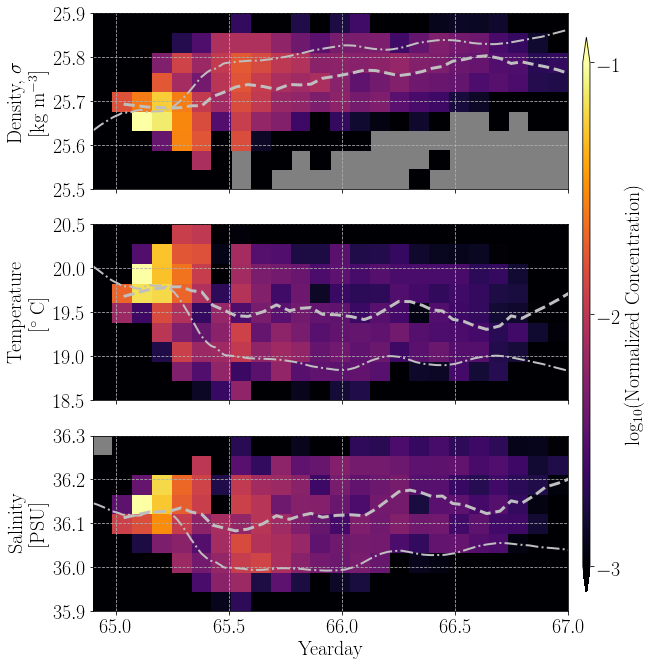

In [8]:
#%% 3 Panel Surface mean concentration
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 20
plt.rcParams['contour.negative_linestyle'] = 'solid'
from matplotlib.ticker import FormatStrFormatter

npcom = 7 # number of smoothing points for COM plot
npfloat = 931 # number of smoothing points for float plot
nx = 25 # number of bins in the time (x) direction
#nx = 50
ny = 12 # number of bins in the (rho, T, S) (y) direction
ny = 10

# Some plotting options
fc = '0.5'
cmap = 'gnuplot'
cmap = 'inferno'
cl = [-3, -1]
norm = np.max(fluorppb_ts)

# Here we mask for finite values, positive concentrations, and correct yeardays
mask =  (fluorppb_ts > 0) & (jday_ts<68) & (np.isfinite(rho_ts))
tempfluor = fluorppb_ts.copy()
#tempfluor[tempfluor<1e-2] = 0 # This is what is done in the COM calc, but here we are averaging which should beat down noise, so we keep these


# Calculate float density and spacing:
si = np.argmin(np.abs(fydr-65))
ei = np.argmin(np.abs(fydr-68))
dstep = (fydr[-1] - fydr[0])/fydr.size
span = int(1/6/dstep)
lims = range(si, ei, span)
SA = gsw.SA_from_SP(fS, fP, -66, 39)
CT = gsw.CT_from_t(SA, fT, fP)
Rf = gsw.rho(SA, CT, 0)
Rf = Rf - 1000


norm = np.nanmax(fluorppb_ts[mask]) # Normalize by maximum float concentration over entire record
xedges = np.linspace(64.9, 67, nx) # Make the edges for the histogram
yedges = np.linspace(25.5, 25.9, ny)

###### CALCULATE AND PLOT RHO #######
# Binned mean is the concentration weighted histogram divided by counts per bin:
denominator, _, _ = np.histogram2d(jday_ts[mask],rho_ts[mask],bins=(xedges, yedges))
nominator, _, _ = np.histogram2d(jday_ts[mask],rho_ts[mask],bins=[xedges, yedges], weights=(tempfluor[mask]/norm))
H = nominator/denominator # This is the binned mean normalized concentration (for rho)

fig, ax = plt.subplots(3,1, sharex=True, figsize=(8, 11))
axrho = ax[0]
ix = axrho.pcolor( xedges, yedges, np.transpose(np.log10(H/np.nansum(H))), vmin=cl[0], vmax=cl[1], cmap=cmap)
#axrho.scatter(fydr[lims], Rf[lims], marker='d', color='cornflowerblue', edgecolor='w', s=150)
axrho.grid(linestyle='--')
#axrho.scatter(jday_sect, rho_COM_SECT, marker='x')
axrho.set_ylim(yedges[0], yedges[-1])
maskF = fS>35.95
#axrho.plot(fydr[maskP], Rf[maskP], linestyle='--', linewidth=2, color='0.75')
yhat = savgol_filter(Rf[maskF], npfloat, 3, mode='nearest') # window size 51, polynomial order 3
axrho.plot(fydr[maskF], yhat, linestyle='-.', linewidth=2, color='0.75')

maskP = (np.isfinite(s_COM_SECT)) & (jday_sect<67.5) & (rho_COM_SECT>20)# &(jday_sect>65)
yhat = savgol_filter(rho_COM_SECT[maskP], npcom, 3) # window size 51, polynomial order 3
axrho.plot(jday_sect[maskP], yhat, linewidth=3, color='0.75', linestyle='--')
axrho.set_ylabel('Density, $\sigma$\n [kg m$^{-3}$]')
#axrho.set_yticks([25.5, 25.75, 26])
axrho.set_facecolor(fc)

###### CALCULATE AND PLOT TEMP #######
axtemp = ax[1]
yedges = np.linspace(18.5, 20.5, ny)
denominator, _, _ = np.histogram2d(jday_ts[mask],T_ts[mask],bins=(xedges, yedges))
nominator, _, _ = np.histogram2d(jday_ts[mask],T_ts[mask],bins=[xedges, yedges], weights=(tempfluor[mask]/norm))
H = nominator/denominator

ix = axtemp.pcolor( xedges, yedges, np.transpose(np.log10(H/np.nansum(H))), vmin=cl[0], vmax=cl[1], cmap=cmap)
#axtemp.scatter(fydr[lims], fT[lims], marker='d', color='cornflowerblue', edgecolor='w', s=150)
axtemp.grid(linestyle='--')
#axtemp.scatter(jday_sect, t_COM_SECT, marker='x')
axtemp.set_ylim(yedges[0], yedges[-1])
#maskP = fS>35.95
#axtemp.plot(fydr[maskP], fT[maskP], linestyle='--', linewidth=2, color='0.75')
yhat = savgol_filter(fT[maskF], npfloat, 3, mode='nearest') # window size 51, polynomial order 3
axtemp.plot(fydr[maskF], yhat, linestyle='-.', linewidth=2, color='0.75')

#maskP = (np.isfinite(s_COM_SECT)) & (jday_sect<67.5)  &(jday_sect>65)
yhat = savgol_filter(t_COM_SECT[maskP], npcom, 3) # window size 51, polynomial order 3
axtemp.plot(jday_sect[maskP], yhat, linewidth=3, color='0.75', linestyle='--')

axtemp.set_facecolor(fc)
axtemp.set_ylabel('Temperature\n [$^{\circ}$ C]')


###### CALCULATE AND PLOT SALINITY #######
axsal = ax[2]
yedges = np.linspace(35.9, 36.3, ny)
#H, xedges, yedges = np.histogram2d(jday_ts[mask], S_ts[mask], weights=(fluorppb_ts[mask]/norm),   bins=(xedges, yedges), density=False)
denominator, _, _ = np.histogram2d(jday_ts[mask],S_ts[mask],bins=(xedges, yedges))
nominator, _, _ = np.histogram2d(jday_ts[mask],S_ts[mask],bins=[xedges, yedges], weights=(tempfluor[mask]/norm))
H = nominator/denominator
ix = axsal.pcolor( xedges, yedges, np.transpose(np.log10(H/np.nansum(H))), vmin=cl[0], vmax=cl[1], cmap=cmap)
#axsal.scatter(fydr[lims], fS[lims], marker='d', color='cornflowerblue', edgecolor='w', s=150)

axsal.grid(linestyle='--')
#axsal.scatter(jday_sect, s_COM_SECT, linewidth=2, marker='o')
#maskP = (np.isfinite(fS)) & (fS>35.95)
#axsal.plot(fydr[maskP], fS[maskP], linestyle='--', linewidth=2, color='0.75')
yhat = savgol_filter(fS[maskF], npfloat, 3, mode='nearest') # window size 51, polynomial order 3
axsal.plot(fydr[maskF], yhat, linestyle='-.', linewidth=2, color='0.75')

#maskP = (np.isfinite(s_COM_SECT)) & (jday_sect<67.5)# &(jday_sect>65)
yhat = savgol_filter(s_COM_SECT[maskP], npcom, 3, mode='nearest') # window size 51, polynomial order 3
axsal.plot(jday_sect[maskP], yhat, linewidth=3, color='0.75', linestyle='--')

axsal.set_facecolor(fc)


axsal.set_ylim(yedges[0], yedges[-1])

axsal.set_xlim(64.9, 67)

axsal.set_ylabel('Salinity\n [PSU]')
axsal.set_xlabel('Yearday')

# Add Colorbar
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.15, 0.0125, 0.7])
cb = fig.colorbar(ix, cax=cbar_ax, extend='both')
cb.set_label('log$_{10}$(Normalized Concentration)')
cb.set_ticks([-4, -3, -2, -1, 0])
cb.solids.set_edgecolor("face") 

#plt.savefig('/data/pacific/jacob/LATMIXDYE/NEWFIGS/DyeDensity_MEAN.pdf', bbox_inches='tight')

## Histogram of dye in T-S space

This makes supplementary figure S1 of Wenegrat et al. 2020

/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log10
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log10


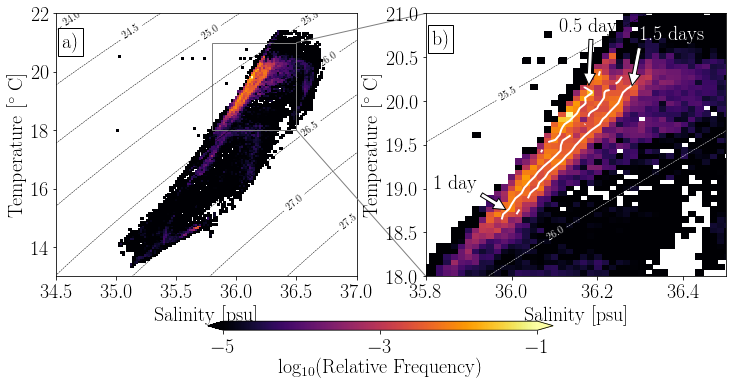

In [9]:
#%% HISTO IN T-S Space 3 panel 

cmap = 'gnuplot'
cmap = 'inferno'
cl = [-5, -1]
norm = np.max(fluorppb_ts)

mask =  (fluorppb_ts > 0) & (jday_ts<67) & (np.isfinite(rho_ts))

# Create the background density contours
xedges = np.linspace(34.5, 37, 150)
yedges = np.linspace(13, 22, 150)
X, Y = np.meshgrid(xedges, yedges)
SA = gsw.SA_from_SP(X, 0, -66, 39)
CT = gsw.CT_from_t(SA, Y, 0)
R = gsw.rho(SA, CT, 0)
R = R - 1000

# Density of float (not used in final figure)
SA = gsw.SA_from_SP(fS, fP, -66, 39)
CT = gsw.CT_from_t(SA, fT, fP)
Rf = gsw.rho(SA, CT, 0)
Rf = Rf - 1000
norm = np.sum(fluorppb_ts[mask])
norm = 1

# Calculate the dye weighted histogram
H, xedges, yedges = np.histogram2d(S_ts[mask], T_ts[mask], weights=(fluorppb_ts[mask]/norm),   bins=(xedges, yedges), density=False)

fig = plt.figure(figsize=(12, 5))

###### CALCULATE HISTOGRAMS #######

axhistot = plt.subplot2grid((2,4), (0,2), rowspan = 2, colspan=2)

# Create a concentration weighted average yearday by dividing the concentration weighted time histogram by the concentration weighted histogram
Htime, xedges, yedges = np.histogram2d(S_ts[mask], T_ts[mask], weights=(fluorppb_ts[mask]*jday_ts[mask]),   bins=(xedges, yedges), density=False)
#Hcount, xedges, yedges = np.histogram2d(S_ts[mask], T_ts[mask],   bins=(xedges, yedges), density=False)
Hf, xedges, yedges = np.histogram2d(S_ts[mask], T_ts[mask],  weights=(fluorppb_ts[mask]), bins=(xedges, yedges), density=False)
Havgtime = Htime/(Hf) # This is the concentration weighted average time

mask = ((np.log10(H/np.sum(H)))>-3) # For plotting purposes mask out very small values of the actual normalized dye concentration
Havgtime[~mask] = np.nan
cmapt = cmap

###### PANEL A: MAIN HISTOGRAM #######
axhisto = plt.subplot2grid((2,4), (0,0), rowspan = 2, colspan=2)
ix = axhisto.pcolor( xedges, yedges, np.transpose(np.log10(H/np.sum(H))), vmin=cl[0], vmax=cl[1], cmap=cmap)
ix.set_edgecolor('face')
conts = np.linspace(20, 30, 21)
CL = axhisto.contour(X, Y, R,conts, colors='k', linestyles='dashed', linewidths=0.5)

axhisto.clabel(CL, inline=1, fontsize=10, fmt='%1.1f')
axhisto.set_xlabel('Salinity [psu]')
axhisto.set_ylabel('Temperature [$^\circ$ C]')
axhisto.text(34.55, 20.85 ,'a)', color='k', size=20, bbox=dict(facecolor='w', edgecolor='k'))

# Draw box around where panel b highlights
margin = .0
min_f0, max_f0 = 35.8 - margin, 36.5 + margin
min_f1, max_f1 = 18 - margin, 21 + margin
width = max_f0 - min_f0
height = max_f1 - min_f1

axhisto.add_patch(
    patches.Rectangle(
        xy=(min_f0, min_f1),  # point of origin.
        width=width,
        height=height,
        linewidth=1,
        color='0.5',
        fill=False
    )
)


###### PANEL B: ZOOMED IN HISTO W/ TIME CONTOURS #######
axinset = plt.subplot2grid((2,4), (0,2), rowspan = 2, colspan=2)
ix = axinset.pcolor( xedges, yedges, np.transpose(np.log10(H/np.sum(H))), vmin=cl[0], vmax=cl[1], cmap=cmap)
ix.set_edgecolor('face')
conts = np.linspace(20, 30, 21)

tconts = 64.87+ np.linspace(0, 5, 11) # 1/2 day contours
tx = axinset.contour( 0.5*(xedges[1:]+xedges[0:-1]), 0.5*(yedges[1:]+yedges[:-1]), np.transpose(Havgtime),  tconts, colors='w', linewidths=2)
#axinset.clabel(tx, inline=1, fontsize=10, fmt='%1.1f')
CL1 = axinset.contour(X, Y, R,[25.5], colors='k', linestyles='dashed', linewidths=0.5)
CL2 = axinset.contour(X, Y, R,[26], colors='w', linestyles='dashed', linewidths=0.5)

#
axinset.set_xlabel('Salinity [psu]')
axinset.set_ylabel('Temperature [$^\circ$ C]')
axinset.set_xlim(35.8, 36.5)
axinset.set_ylim(18, 21)
axinset.clabel(CL1, inline=1, fontsize=10, fmt='%1.1f', manual=[(36,20)])
axinset.clabel(CL2, inline=1, fontsize=10, fmt='%1.1f', manual=[(36.1, 18.5)])

#b.ax.xaxis.set_ticks_position('top')

con = ConnectionPatch(xyA=(36.5, 21), xyB=(35.8, 21), coordsA="data", coordsB="data",
                      axesA=axhisto, axesB=axinset, color="0.5")
axinset.add_artist(con)

con = ConnectionPatch(xyA=(36.5, 18), xyB=(35.8, 18), coordsA="data", coordsB="data",
                      axesA=axhisto, axesB=axinset, color="0.5")
axinset.add_artist(con)

axinset.annotate('0.5 days', xy=(36.18, 20.15), xytext=(36.11, 20.8),color='k',
            arrowprops=dict(facecolor='w', shrink=0.05),
            )

axinset.annotate('1 day', xy=(35.99, 18.75), xytext=(35.82, 19),color='k',
            arrowprops=dict(facecolor='w', shrink=0.05),
            )
axinset.annotate('1.5 days', xy=(36.28, 20.15), xytext=(36.3, 20.7),color='w',
            arrowprops=dict(facecolor='w', shrink=0.05),
            )

plt.subplots_adjust(wspace=0.6)
axinset.text(35.815, 20.65 ,'b)', color='k', size=20, bbox=dict(facecolor='w', edgecolor='k'))



#fig.colorbar(ix,  ax=[axhisto, axinset], orientation='horizontal')
#ax_cbar1 = fig.add_axes([0.3, 0, 0.4, 0.1])
fig.subplots_adjust(bottom=0.15)

ax_cbar1 = fig.add_axes([0.3, 0, 0.4, 0.025])
cb = plt.colorbar(ix, cax=ax_cbar1, orientation='horizontal', extend='both', pad=5)
#axs['5'].contour(jd, sd, grid_surf_rho, 5)
cb.set_ticks([-5,  -3,  -1])
#cb = plt.colorbar(ix, extend='both')
cb.set_label('log$_{10}$(Relative Frequency)')

#axs['5'].set_xlim([64.75, 67])
#axsurf.set_ylim(-10, 10)
#plt.scatter(S_ts[mask], T_ts[mask], c=np.log10(fluorppb_ts[mask]/norm), s=1)
#plt.savefig('/home/jacob/Dropbox/GulfStreamDye/LATMIXSCIENCE/DyeDensity.pdf', bbox_inches='tight')
#plt.savefig('/data/pacific/jacob/LATMIXDYE/NEWFIGS/DyeDensity_REV.pdf', bbox_inches='tight')

## Dye 3 panel with histogram 
Instead of plotting mean concentration we could plot normalized relative frequency.
This is not used in the MS

/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log10
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log10
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in log10


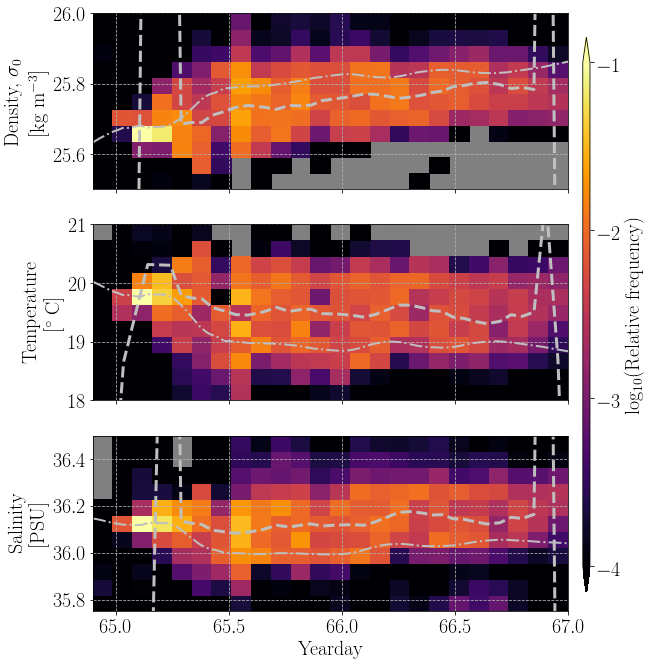

In [8]:
#%% 3 Panel Surface HISTOGRAM
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 20
plt.rcParams['contour.negative_linestyle'] = 'solid'
from matplotlib.ticker import FormatStrFormatter

npcom = 7 # number of smoothing points for COM plot
npfloat = 931 # number of smoothing points for float plot
nx = 25
ny = 12
fc = '0.5'
cmap = 'gnuplot'
cmap = 'inferno'
cl = [-4, -1]
norm = np.max(fluorppb_ts)
mask = (fluorppb_ts/norm>10**(cl[0])) & (jday_ts<68) & (np.isfinite(rho_ts))
mask =  (fluorppb_ts > 0) & (jday_ts<68) & (np.isfinite(rho_ts))
tempfluor = fluorppb_ts.copy()
#tempfluor = 0*tempfluor + 1
#tempfluor[tempfluor<0] = 0
#mask = jday_ts<90
xedges = np.linspace(34.5, 37, 150)
yedges = np.linspace(13, 22, 150)
X, Y = np.meshgrid(xedges, yedges)
SA = gsw.SA_from_SP(X, 0, -66, 39)
CT = gsw.CT_from_t(SA, Y, 0)
R = gsw.rho(SA, CT, 0)
R = R - 1000
si = np.argmin(np.abs(fydr-65))
ei = np.argmin(np.abs(fydr-68))
dstep = (fydr[-1] - fydr[0])/fydr.size
span = int(1/6/dstep)

lims = range(si, ei, span)
SA = gsw.SA_from_SP(fS, fP, -66, 39)
CT = gsw.CT_from_t(SA, fT, fP)
Rf = gsw.rho(SA, CT, 0)
Rf = Rf - 1000
norm = np.sum(fluorppb_ts[mask])
norm = 1
xedges = np.linspace(64.9, 67, nx)
yedges = np.linspace(25.5, 26, ny)
H, xedges, yedges = np.histogram2d(jday_ts[mask], rho_ts[mask], weights=(tempfluor[mask]/norm),   bins=(xedges, yedges), density=False)

# Get the colormap colors
#cmap = plt.cm.gnuplot

fig, ax = plt.subplots(3,1, sharex=True, figsize=(8, 11))
axrho = ax[0]
ix = axrho.pcolor( xedges, yedges, np.transpose(np.log10(H/np.nansum(H))), vmin=cl[0], vmax=cl[1], cmap=cmap)
#axrho.scatter(fydr[lims], Rf[lims], marker='d', color='cornflowerblue', edgecolor='w', s=150)
axrho.grid(linestyle='--')
#axrho.scatter(jday_sect, rho_COM_SECT, marker='x')
axrho.set_ylim(yedges[0], yedges[-1])
maskP = fS>35.95
#axrho.plot(fydr[maskP], Rf[maskP], linestyle='--', linewidth=2, color='0.75')
yhat = savgol_filter(Rf[maskP], npfloat, 3, mode='nearest') # window size 51, polynomial order 3
axrho.plot(fydr[maskP], yhat, linestyle='-.', linewidth=2, color='0.75')

maskP = (np.isfinite(s_COM_SECT)) & (jday_sect<67.5) #&(cross_mask)
yhat = savgol_filter(rho_COM_SECT[maskP], npcom, 3) # window size 51, polynomial order 3
axrho.plot(jday_sect[maskP], yhat, linewidth=3, color='0.75', linestyle='--')
axrho.set_ylabel('Density, $\sigma_0$\n [kg m$^{-3}$]')
#axrho.set_yticks([25.5, 25.75, 26])
axrho.set_facecolor(fc)

##### TEMPERATURE ########
axtemp = ax[1]
yedges = np.linspace(18, 21, ny)
H, xedges, yedges = np.histogram2d(jday_ts[mask], T_ts[mask], weights=(fluorppb_ts[mask]/norm),   bins=(xedges, yedges), density=False)
ix = axtemp.pcolor( xedges, yedges, np.transpose(np.log10(H/np.nansum(H))), vmin=cl[0], vmax=cl[1], cmap=cmap)
#axtemp.scatter(fydr[lims], fT[lims], marker='d', color='cornflowerblue', edgecolor='w', s=150)
axtemp.grid(linestyle='--')
#axtemp.scatter(jday_sect, t_COM_SECT, marker='x')
axtemp.set_ylim(yedges[0], yedges[-1])
maskP = fS>35.95
#axtemp.plot(fydr[maskP], fT[maskP], linestyle='--', linewidth=2, color='0.75')
yhat = savgol_filter(fT[maskP], npfloat, 3, mode='nearest') # window size 51, polynomial order 3
axtemp.plot(fydr[maskP], yhat, linestyle='-.', linewidth=2, color='0.75')

maskP = (np.isfinite(s_COM_SECT)) & (jday_sect<67.5) #& (cross_mask)
yhat = savgol_filter(t_COM_SECT[maskP], npcom, 3) # window size 51, polynomial order 3
axtemp.plot(jday_sect[maskP], yhat, linewidth=3, color='0.75', linestyle='--')

axtemp.set_facecolor(fc)
axtemp.set_ylabel('Temperature\n [$^{\circ}$ C]')
##### SALINITY #####
axsal = ax[2]
yedges = np.linspace(35.75, 36.5, ny)
H, xedges, yedges = np.histogram2d(jday_ts[mask], S_ts[mask], weights=(fluorppb_ts[mask]/norm),   bins=(xedges, yedges), density=False)
ix = axsal.pcolor( xedges, yedges, np.transpose(np.log10(H/np.nansum(H))), vmin=cl[0], vmax=cl[1], cmap=cmap)
#axsal.scatter(fydr[lims], fS[lims], marker='d', color='cornflowerblue', edgecolor='w', s=150)

axsal.grid(linestyle='--')
#axsal.scatter(jday_sect, s_COM_SECT, linewidth=2, marker='o')
maskP = (np.isfinite(fS)) & (fS>35.95)
#axsal.plot(fydr[maskP], fS[maskP], linestyle='--', linewidth=2, color='0.75')
yhat = savgol_filter(fS[maskP], npfloat, 3, mode='nearest') # window size 51, polynomial order 3
axsal.plot(fydr[maskP], yhat, linestyle='-.', linewidth=2, color='0.75')

maskP = (np.isfinite(s_COM_SECT)) & (jday_sect<67.5)# &(cross_mask)
yhat = savgol_filter(s_COM_SECT[maskP], npcom, 3, mode='nearest') # window size 51, polynomial order 3
axsal.plot(jday_sect[maskP], yhat, linewidth=3, color='0.75', linestyle='--')

axsal.set_facecolor(fc)


axsal.set_ylim(yedges[0], yedges[-1])

axsal.set_xlim(64.9, 67)

axsal.set_ylabel('Salinity\n [PSU]')
axsal.set_xlabel('Yearday')
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.15, 0.0125, 0.7])
cb = fig.colorbar(ix, cax=cbar_ax, extend='both')
cb.set_label('log$_{10}$(Relative frequency)')
cb.set_ticks([-4, -3, -2, -1, 0])
cb.solids.set_edgecolor("face") 

#plt.savefig('/data/pacific/jacob/LATMIXDYE/NEWFIGS/DyeDensity_HIST.pdf', bbox_inches='tight')

## Extras

Some misc. plots and exploratory code not used in the manuscript

/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log10


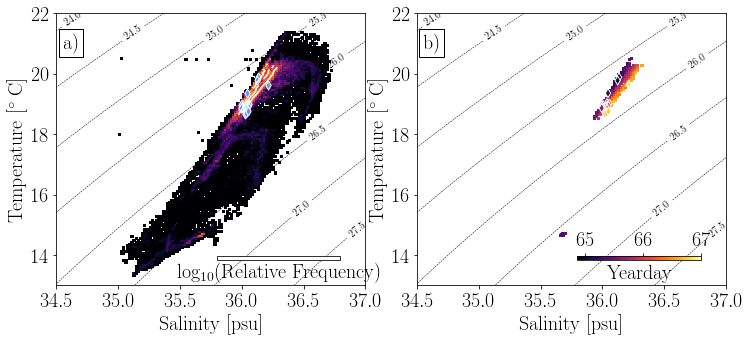

In [163]:
#%% HISTO IN T-S Space 3 panel 

cmap = 'gnuplot'
cmap = 'inferno'
cl = [-5, -1]
norm = np.max(fluorppb_ts)
mask = (fluorppb_ts/norm>10**(cl[0])) & (jday_ts<67)
mask =  (fluorppb_ts > 0) & (jday_ts<67) & (np.isfinite(rho_ts))

#mask = jday_ts<90
xedges = np.linspace(34.5, 37, 150)
yedges = np.linspace(13, 22, 150)
X, Y = np.meshgrid(xedges, yedges)
SA = gsw.SA_from_SP(X, 0, -66, 39)
CT = gsw.CT_from_t(SA, Y, 0)
R = gsw.rho(SA, CT, 0)
R = R - 1000

SA = gsw.SA_from_SP(fS, fP, -66, 39)
CT = gsw.CT_from_t(SA, fT, fP)
Rf = gsw.rho(SA, CT, 0)
Rf = Rf - 1000
norm = np.sum(fluorppb_ts[mask])
norm = 1
H, xedges, yedges = np.histogram2d(S_ts[mask], T_ts[mask], weights=(fluorppb_ts[mask]/norm),   bins=(xedges, yedges), density=False)
#fig = plt.figure(figsize=(12.78, 9.41))

fig = plt.figure(figsize=(12, 5))

# TIME-PLOT
axhistot = plt.subplot2grid((2,4), (0,2), rowspan = 2, colspan=2)

Htime, xedges, yedges = np.histogram2d(S_ts[mask], T_ts[mask], weights=(fluorppb_ts[mask]*jday_ts[mask]),   bins=(xedges, yedges), density=False)
Hcount, xedges, yedges = np.histogram2d(S_ts[mask], T_ts[mask],   bins=(xedges, yedges), density=False)
Hf, xedges, yedges = np.histogram2d(S_ts[mask], T_ts[mask],  weights=(fluorppb_ts[mask]), bins=(xedges, yedges), density=False)

Havgtime = Htime/(Hf) # This is the concentration weighted average time

mask = ((np.log10(H/np.sum(H)))>-3)
Havgtime[~mask] = np.nan
#Havgtime = Htime/Hcount
cmapt = cmap

ix = axhistot.pcolor( xedges, yedges, np.transpose(Havgtime),  cmap=cmapt, vmin=64.87, vmax=67)
ix.set_edgecolor('face')
#axhisto.grid()
conts = np.linspace(20, 30, 21)
CL = axhistot.contour(X, Y, R,conts, colors='k', linestyles='dashed', linewidths=0.5)
axhistot.clabel(CL, inline=1, fontsize=10, fmt='%1.1f')
axhistot.set_xlabel('Salinity [psu]')
axhistot.set_ylabel('Temperature [$^\circ$ C]')
si = np.argmin(np.abs(fydr-65))
ei = np.argmin(np.abs(fydr-68))
dstep = (fydr[-1] - fydr[0])/fydr.size
span = int(1/6/dstep)
lims = range(si, ei, span)
axhistot.scatter(fS[lims], fT[lims], c = fydr[lims], marker='d', edgecolor='w', s=40, cmap=cmapt, vmin=64.87, vmax=68)
axhistot.text(34.55, 20.85 ,'b)', color='k', size=20, bbox=dict(facecolor='w', edgecolor='k'))

cbaxes = inset_axes(axhistot, width="40%", height="1.5%", loc=4, borderpad=1.25) 

cb = plt.colorbar(ix,cax=cbaxes,orientation='horizontal',)
cb.ax.xaxis.set_ticks_position('top')
cb.set_ticks([65, 66, 67])
#cb = plt.colorbar(ix, extend='both')
cb.set_label('Yearday')

# COLORED HISTOGRAM
axhisto = plt.subplot2grid((2,4), (0,0), rowspan = 2, colspan=2)
ix = axhisto.pcolor( xedges, yedges, np.transpose(np.log10(H/np.sum(H))), vmin=cl[0], vmax=cl[1], cmap=cmap)
ix.set_edgecolor('face')
conts = np.linspace(20, 30, 21)
CL = axhisto.contour(X, Y, R,conts, colors='k', linestyles='dashed', linewidths=0.5)

tconts = 64.87+ np.linspace(0, 5, 11) # 1/2 day contours
ix = axhisto.contour( 0.5*(xedges[1:]+xedges[0:-1]), 0.5*(yedges[1:]+yedges[:-1]), np.transpose(Havgtime),  tconts, colors='w')


axhisto.clabel(CL, inline=1, fontsize=10, fmt='%1.1f')
axhisto.set_xlabel('Salinity [psu]')
axhisto.set_ylabel('Temperature [$^\circ$ C]')
#si = np.argmin(np.abs(fydr-65))
#dstep = (fydr[-1] - fydr[0])/fydr.size
#span = int(1/6/dstep)
#lims = range(si, fydr.size, span)
axhisto.scatter(fS[lims], fT[lims], marker='d', color='cornflowerblue', edgecolor='w', s=40)
axhisto.text(34.55, 20.85 ,'a)', color='k', size=20, bbox=dict(facecolor='w', edgecolor='k'))

#cbaxes = inset_axes(axhisto, width="1%", height="60%", loc=6) 
#cb = plt.colorbar(ix, cax=cbaxes, extend='both')
cbaxes = inset_axes(axhisto, width="40%", height="1.5%", loc=4, borderpad=1.25) 

cb = plt.colorbar(ix,cax=cbaxes,orientation='horizontal', extend='both')
cb.ax.xaxis.set_ticks_position('top')
cb.set_ticks([-5,  -3,  -1])
#cb = plt.colorbar(ix, extend='both')
cb.set_label('log$_{10}$(Relative Frequency)')



cb.ax.xaxis.set_ticks_position('top')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

#axs['5'].contour(jd, sd, grid_surf_rho, 5)
#axs['5'].set_xlim([64.75, 67])
#axsurf.set_ylim(-10, 10)
#plt.scatter(S_ts[mask], T_ts[mask], c=np.log10(fluorppb_ts[mask]/norm), s=1)

#plt.savefig('/home/jacob/Dropbox/GulfStreamDye/LATMIXSCIENCE/DyeDensity.pdf', bbox_inches='tight')

(18, 21)

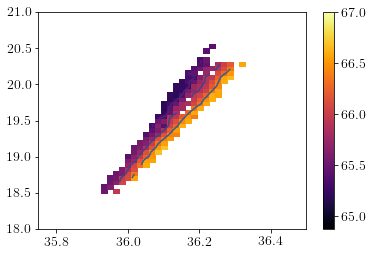

In [49]:
plt.pcolor( xedges, yedges, np.transpose(Havgtime),  cmap=cmapt, vmin=64.87, vmax=67)
plt.colorbar()
plt.contour( 0.5*(xedges[1:]+xedges[0:-1]), 0.5*(yedges[1:]+yedges[:-1]), np.transpose(Havgtime), 64.87+ np.linspace(0, 5, 11))
plt.xlim(35.75, 36.5)
plt.ylim(18, 21)


In [48]:
64.87+ np.linspace(0, 5, 11)

array([64.87, 65.37, 65.87, 66.37, 66.87, 67.37, 67.87, 68.37, 68.87,
       69.37, 69.87])

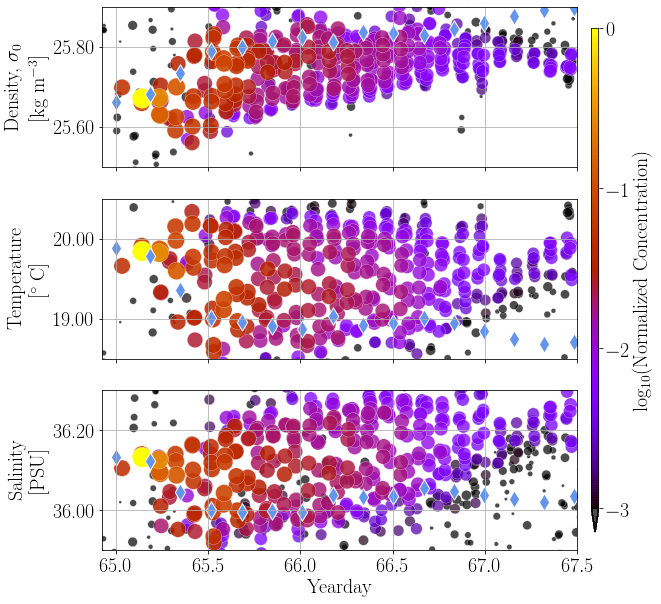

In [257]:
#%% 3 Panel Surface MANUSCRIPT
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 20
plt.rcParams['contour.negative_linestyle'] = 'solid'
from matplotlib.ticker import FormatStrFormatter

cmap = 'gnuplot'
cl = [-5, -1]
norm = np.max(fluorppb_ts)
mask = (fluorppb_ts/norm>10**(cl[0])) & (jday_ts<68)
#mask = jday_ts<90
xedges = np.linspace(34.5, 37, 150)
yedges = np.linspace(13, 22, 150)
X, Y = np.meshgrid(xedges, yedges)
SA = gsw.SA_from_SP(X, 0, -66, 39)
CT = gsw.CT_from_t(SA, Y, 0)
R = gsw.rho(SA, CT, 0)
R = R - 1000
si = np.argmin(np.abs(fydr-65))
ei = np.argmin(np.abs(fydr-68))
dstep = (fydr[-1] - fydr[0])/fydr.size
span = int(1/6/dstep)

lims = range(si, ei, span)
SA = gsw.SA_from_SP(fS, fP, -66, 39)
CT = gsw.CT_from_t(SA, fT, fP)
Rf = gsw.rho(SA, CT, 0)
Rf = Rf - 1000
norm = np.sum(fluorppb_ts[mask])
norm = 1
H, xedges, yedges = np.histogram2d(S_ts[mask], T_ts[mask], weights=(fluorppb_ts[mask]/norm),   bins=(xedges, yedges), density=False)

# Get the colormap colors
cmap = plt.cm.gnuplot
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0.7, 1, cmap.N)

# Create new colormap
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(my_cmap)

#fig = plt.figure(figsize=(12.78, 9.41))
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8, 10))
normscatter=np.max(fluor_int)
mask = fluor_int/normscatter>1e-4

x = jday_int[mask]
z = (fluor_int[mask]/normscatter)
yt =[]
yt.append(zcom_rhoi[mask])
yt.append(zcom_ti[mask])
yt.append(zcom_si[mask])
fYt = []
fYt.append(Rf[lims])
fYt.append(fT[lims])
fYt.append(fS[lims])
ylims = []
ylims.append([25.5, 25.9])
#ylims.append([25.72, 25.82])

ylims.append([18.5, 20.5])
ylims.append([35.9, 36.3])
yticks = []
yticks.append([25.6, 25.75, 25.8])
#yticks.append([25.5, 25.6, 25.7, 25.8])

yticks.append([18, 19.5 ,21])
yticks.append([35.75, 36, 36.25, 36.5])
titles =[]
titles.append('Density, $\sigma_0$\n [kg m$^{-3}$]')
titles.append('Temperature\n [$^{\circ}$ C]')
titles.append('Salinity\n [PSU]')
cl=[-3, 0]
for i in range (0, 3):
    #axsurf = plt.subplot2grid((3,4), (i,0), rowspan=1, colspan=4)
    axsurf = ax[i]
    axsurf.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    normscatter = np.nanmax(fluor_int)
    axsurf.grid()
    y = yt[i]
    x = jday_int[mask]
    c = np.log10(fluor_int[mask]/normscatter)
    s = 1e2*np.log10(1e4*fluor_int[mask]/normscatter)
    sortinds = np.argsort(c)
    c = c[sortinds]; s = s[sortinds]; x = x[sortinds]; y=y[sortinds]
    ix = axsurf.scatter(x, y, c=c,s=s, edgecolor='w',linewidth=0.25, cmap=my_cmap, vmin=cl[0], vmax=cl[1])
    axsurf.scatter(fydr[lims], fYt[i], marker='d', color='cornflowerblue', edgecolor='w', s=150)
    axsurf.set_ylabel(titles[i])
    axsurf.set_xlim(64.925, 67.5)
    #axsurf.set_xlim(65.1, 65.8)
    axsurf.set_ylim(ylims[i][0], ylims[i][-1])
    #axsurf.set_yticks(yticks[i])
#axsurf.annotate("", xy=(65.14, yticks[i][0]), xytext=(65.14, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.24, yticks[i][0]), xytext=(65.24, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.33, yticks[i][0]), xytext=(65.33, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.53, yticks[i][0]), xytext=(65.53, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))

axsurf.set_xlabel('Yearday')
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.15, 0.0125, 0.7])
cb = fig.colorbar(ix, cax=cbar_ax, extend='min')
cb.set_label('log$_{10}$(Normalized Concentration)')
cb.set_ticks([-3, -2, -1, 0])
cb.solids.set_edgecolor("face") 

plt.subplots_adjust(hspace=0.2)

#plt.savefig('/data/pacific/jacob/LATMIXDYE/NEWFIGS/DyeDensity_2.pdf', bbox_inches='tight')


In [ ]:
cmapt

In [ ]:
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0.7, 1, cmap.N)

# Create new colormap
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(my_cmap)

#fig = plt.figure(figsize=(12.78, 9.41))
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8, 10))
normscatter=np.max(fluor_int)
mask = fluor_int/normscatter>1e-4

x = jday_int[mask]
z = (fluor_int[mask]/normscatter)
yt =[]
yt.append(zcom_rhoi[mask])
yt.append(zcom_ti[mask])
yt.append(zcom_si[mask])
fYt = []
fYt.append(Rf[lims])
fYt.append(fT[lims])
fYt.append(fS[lims])
ylims = []
ylims.append([25.6, 25.9])
#ylims.append([25.72, 25.82])

ylims.append([18, 21.25])
ylims.append([35.75, 36.5])
yticks = []
yticks.append([25.6, 25.75, 25.8])
#yticks.append([25.5, 25.6, 25.7, 25.8])

yticks.append([18, 19.5 ,21])
yticks.append([35.75, 36, 36.25, 36.5])
titles =[]
titles.append('Density, $\sigma_0$\n [kg m$^{-3}$]')
titles.append('Temperature\n [$^{\circ}$ C]')
titles.append('Salinity\n [PSU]')
cl=[-3, 0]
for i in range (0, 3):
    #axsurf = plt.subplot2grid((3,4), (i,0), rowspan=1, colspan=4)
    axsurf = ax[i]
    axsurf.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    normscatter = np.nanmax(fluor_int)
    axsurf.grid()
    y = yt[i]
    x = jday_int[mask]
    c = np.log10(fluor_int[mask]/normscatter)
    s = 1e2*np.log10(1e4*fluor_int[mask]/normscatter)
    sortinds = np.argsort(c)
    c = c[sortinds]; s = s[sortinds]; x = x[sortinds]; y=y[sortinds]
    ix = axsurf.scatter(x, y, c=c,s=s, edgecolor='w',linewidth=0.25, cmap=my_cmap, vmin=cl[0], vmax=cl[1])
    axsurf.scatter(fydr[lims], fYt[i], marker='d', color='cornflowerblue', edgecolor='w', s=150)
    axsurf.set_ylabel(titles[i])
    axsurf.set_xlim(64.925, 67.5)
    #axsurf.set_xlim(65.1, 65.8)
    axsurf.set_ylim(ylims[i][0], ylims[i][-1])
    axsurf.set_yticks(yticks[i])
#axsurf.annotate("", xy=(65.14, yticks[i][0]), xytext=(65.14, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.24, yticks[i][0]), xytext=(65.24, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.33, yticks[i][0]), xytext=(65.33, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.53, yticks[i][0]), xytext=(65.53, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))

axsurf.set_xlabel('Yearday')
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.15, 0.0125, 0.7])
cb = fig.colorbar(ix, cax=cbar_ax, extend='min')
cb.set_label('log$_{10}$(Normalized Concentration)')
cb.set_ticks([-3, -2, -1, 0])
cb.solids.set_edgecolor("face") 

plt.subplots_adjust(hspace=0.2)

#plt.savefig('/data/pacific/jacob/LATMIXDYE/NEWFIGS/DyeDensity_2.pdf', bbox_inches='tight')

In [ ]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D



fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection='3d')

mask = (fluor_int/normscatter>1e-4) & (zcom_si>35)



ax.scatter(jday_int[mask]*10, zcom_si[mask], zcom_ti[mask],c=np.log10(fluor_int[mask]/normscatter), s=1e2*np.log10(1e4*fluor_int[mask]/normscatter), marker='o',
           cmap=cmap, vmin=-3, vmax=0)

#ax.auto_scale_xyz([64, 100], [35, 36.5], [15, 21])

In [ ]:
#%% 3 Panel Surface 
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 20
plt.rcParams['contour.negative_linestyle'] = 'solid'
from matplotlib.ticker import FormatStrFormatter

cmap = 'gnuplot'
cl = [-5, -1]
norm = np.max(fluorppb_ts)
mask = (fluorppb_ts/norm>10**(cl[0])) & (jday_ts<68)
#mask = jday_ts<90
xedges = np.linspace(34.5, 37, 150)
yedges = np.linspace(13, 22, 150)
X, Y = np.meshgrid(xedges, yedges)
SA = gsw.SA_from_SP(X, 0, -66, 39)
CT = gsw.CT_from_t(SA, Y, 0)
R = gsw.rho(SA, CT, 0)
R = R - 1000
si = np.argmin(np.abs(fydr-65))
ei = np.argmin(np.abs(fydr-68))
dstep = (fydr[-1] - fydr[0])/fydr.size
span = int(1/6/dstep)

lims = range(si, ei, span)
SA = gsw.SA_from_SP(fS, fP, -66, 39)
CT = gsw.CT_from_t(SA, fT, fP)
Rf = gsw.rho(SA, CT, 0)
Rf = Rf - 1000
norm = np.sum(fluorppb_ts[mask])
norm = 1
H, xedges, yedges = np.histogram2d(S_ts[mask], T_ts[mask], weights=(fluorppb_ts[mask]/norm),   bins=(xedges, yedges), density=False)

# Get the colormap colors
cmap = plt.cm.gnuplot
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0.7, 1, cmap.N)

# Create new colormap
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(my_cmap)

#fig = plt.figure(figsize=(12.78, 9.41))
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8, 10))
normscatter=np.max(fluor_int)
#mask = fluor_int/normscatter>1e-4
norm = np.sum(fluorppb_ts[mask])

x = jday_ts[mask]
z = (fluorppb_ts[mask]/norm)
yt =[]
yt.append(T_ts[mask])
yt.append(T_ts[mask])
yt.append(S_ts[mask])
fYt = []
fYt.append(Rf[lims])
fYt.append(fT[lims])
fYt.append(fS[lims])
ylims = []
#ylims.append([25.6, 25.9])
#ylims.append([25.72, 25.82])
ylims.append([18, 21.25])

ylims.append([18, 21.25])
ylims.append([35.75, 36.5])
yticks = []
yticks.append([25.6, 25.75, 25.8])
#yticks.append([25.5, 25.6, 25.7, 25.8])

yticks.append([18, 19.5 ,21])
yticks.append([35.75, 36, 36.25, 36.5])
titles =[]
titles.append('Density, $\sigma_0$\n [kg m$^{-3}$]')
titles.append('Temperature\n [$^{\circ}$ C]')
titles.append('Salinity\n [PSU]')
cl=[-3, 0]
for i in range (0, 3):
    #axsurf = plt.subplot2grid((3,4), (i,0), rowspan=1, colspan=4)
    axsurf = ax[i]
    axsurf.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    normscatter = np.nanmax(fluor_int)
    axsurf.grid()
    y = yt[i]
    x = jday_ts[mask]
    c = np.log10(z)
    s = 1e4*np.log10(1e4*z)
    s = 50 + 0*s
    sortinds = np.argsort(c)
    c = c[sortinds]; s = s[sortinds]; x = x[sortinds]; y=y[sortinds]
    ix = axsurf.scatter(x, y, c=c,s=s, edgecolor='w',linewidth=0.25, cmap=my_cmap, vmin=cl[0], vmax=cl[1])
    axsurf.scatter(fydr[lims], fYt[i], marker='d', color='cornflowerblue', edgecolor='w', s=150)
    axsurf.set_ylabel(titles[i])
    axsurf.set_xlim(64.925, 67.5)
    #axsurf.set_xlim(65.1, 65.8)
    axsurf.set_ylim(ylims[i][0], ylims[i][-1])
    axsurf.set_yticks(yticks[i])
#axsurf.annotate("", xy=(65.14, yticks[i][0]), xytext=(65.14, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.24, yticks[i][0]), xytext=(65.24, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.33, yticks[i][0]), xytext=(65.33, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))
#axsurf.annotate("", xy=(65.53, yticks[i][0]), xytext=(65.53, yticks[i][0]*0.9965),arrowprops=dict(arrowstyle="->"))

axsurf.set_xlabel('Yearday')
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.15, 0.0125, 0.7])
cb = fig.colorbar(ix, cax=cbar_ax, extend='min')
cb.set_label('log$_{10}$(Normalized Concentration)')
cb.set_ticks([-3, -2, -1, 0])
cb.solids.set_edgecolor("face") 

plt.subplots_adjust(hspace=0.2)

#plt.savefig('/data/pacific/jacob/LATMIXDYE/NEWFIGS/DyeDensity_2.pdf', bbox_inches='tight')


In [ ]:
plt.plot(c)
plt.plot(np.log10(z))

NameError: name 'rho_COM_SECT' is not defined

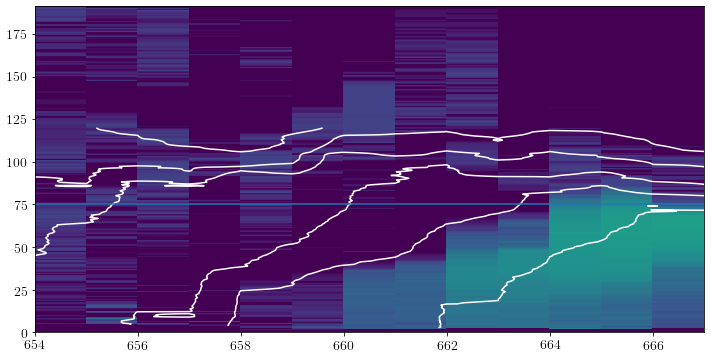

In [152]:
fluorppb.shape
rhoc = np.linspace(20, 30, 101)+0.1 # Contours of rho


span = range(0, 200)
span = range(200, 400)
span = range(400, 600)
span = range(600,800)
#span = range(800, 1000)
si = 35
span = range(II[si,0], II[si,1])
plt.figure(figsize=(12,6))
plt.pcolor(span, depth[0:,span], np.log10(fluorppb[0:,span]/np.nanmax(fluorppb)), vmin=-4, vmax=-1)
plt.contour(span, depth[0:1200,0], rho[0:1200,span], rhoc, colors='w')
plt.axhline(75)

plt.contour(span, depth[0:1200,0], rho[0:1200,span], [rho_COM_SECT[si]], colors='r')

plt.gca().invert_yaxis()
for i in range(0,nc):
    if (II[i,0]>span[0])&(II[i,0]<span[-1]):
        plt.axvline(II[i,0])
        plt.text(II[i,0], 0, i)
    
    
plt.xlim(span[0], span[-1])

#cross_mask = [False, True, False, True, False, True, True, True, True]
plt.figure()

plt.plot(span, integrate.trapz(fluorppb[0:,span], x=depth[:,0], axis=0))

In [153]:
# set crossing mask (manually pick out 'valid' crossings)
cross_mask = 0*np.ones((nc,)).astype('int')
cross_mask[2] = 1
cross_mask[4] = 1
cross_mask[6] = 1
cross_mask[7] = 1
cross_mask[8] = 1
#cross_mask[9] = 1 # marginal (could be OK?)
cross_mask[10:20] = 1
cross_mask[20:30] = 1
cross_mask[30:40] = 1   
cross_mask[37] = 0 #ad hoc...
cross_mask[40] = 1
#cross_mask[41] = 1
cross_mask[42] = 1
cross_mask[44] = 1
cross_mask[46] = 1
cross_mask[48] = 1
#cross_mask[49]
cross_mask[50:54] = 1
cross_mask = cross_mask.astype('bool')
plt.figure(figsize=(12,12))
plt.plot(jday_sect[cross_mask], rho_COM_SECT[cross_mask], marker='x')
plt.scatter(jday_sect, rho_COM_SECT, marker='x', color='r')
for i, txt in enumerate(range(0,nc)):
    plt.annotate(txt, (jday_sect[i], rho_COM_SECT[i]))
plt.xlim(66, 68)

NameError: name 'nc' is not defined

/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


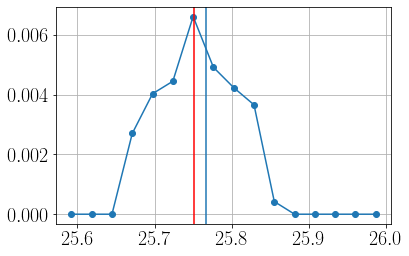

In [316]:
# Compare the COM with the normalize dconcentration plot
mask =  (fluorppb_ts > 0) & (jday_ts<68) & (np.isfinite(rho_ts))
npcom = 5
ny = 20
xedges = np.linspace(64.9, 67, nx)
yedges = np.linspace(25.5, 26, ny)

tempfluor[fluorppb_ts<1e-2] = 0

denominator, _, _ = np.histogram2d(jday_ts[mask],rho_ts[mask],bins=(xedges, yedges))
nominator, _, _ = np.histogram2d(jday_ts[mask],rho_ts[mask],bins=[xedges, yedges], weights=(tempfluor[mask]/norm))
# Get the colormap colors
#cmap = plt.cm.gnuplot
H = nominator/denominator

maskP = (np.isfinite(s_COM_SECT)) & (jday_sect<67.5) #&(cross_mask)
yhat = savgol_filter(rho_COM_SECT[maskP], npcom, 3) # window size 51, polynomial order 3
#H, xedges, yedges = np.histogram2d(jday_ts[mask], rho_ts[mask], weights=(tempfluor[mask]/norm),   bins=(xedges, yedges), density=False)
#H = H/np.nansum(H)
np.nanmax(H)

H.shape
secnum = 11
plt.plot(0.5*(yedges[1:]+yedges[:-1]), H[secnum,:], marker='o')
plt.grid()
ind = np.argmin(np.abs(xedges[secnum] - jday_sect))
plt.axvline(yhat[ind])
plt.axvline(rho_COM_SECT[ind], color='r')

